In [5]:
import pandas as pd
import os 

input_files = '../model_collocated_10d_expanded/'
output_files = '../model_collocated_10d_filled/'

def interpolate_values(row, base_col_name):
    relevant_cols = [col for col in final_df.columns if col.startswith(base_col_name)]
    heights = [float(col.split('_height')[-1]) for col in relevant_cols]
    relevant_cols_sorted = [col for _, col in sorted(zip(heights, relevant_cols))]
    interpolated_values = row[relevant_cols_sorted].interpolate(limit_direction='both', method='linear')
    row[relevant_cols_sorted] = row[relevant_cols_sorted].fillna(interpolated_values)
    return row


files = [f for f in os.listdir(input_files) if f.endswith('.feather') and os.path.isfile(os.path.join(input_files, f))]
dates = [os.path.splitext(f)[0] for f in files]

for date in dates:
    filename = f'{output_files}/{date}.feather'
    
    if os.path.isfile(filename) == False:
        filename = f'{input_files}/{date}.feather'
        file = pd.read_feather(filename)
        file = file.drop(columns=['HEIGHT', 'DATE'])
        
        file['id'] = file.groupby(['LATITUDE', 'LONGITUDE']).ngroup()
        file = file[file['HEIGHT_MODEL'] > -1000]
        file['HEIGHT_MODEL'] = file['HEIGHT_MODEL']*-1
        
        # reshape ASAL values
        pivoted_asal = file.pivot_table(index='id', columns='HEIGHT_MODEL', values='ASAL', aggfunc='mean')
        pivoted_asal.columns = [f'ASAL_height{col}' for col in pivoted_asal.columns]
        
        # reshape CTEMP values
        pivoted_ctemp = file.pivot_table(index='id', columns='HEIGHT_MODEL', values='CTEMP', aggfunc='mean')
        pivoted_ctemp.columns = [f'CTEMP_height{col}' for col in pivoted_ctemp.columns]
        
        merged_df = pd.merge(pivoted_asal.reset_index(), pivoted_ctemp.reset_index(), on='id', how='outer')
        
        ref_df = file[['id', 'LATITUDE', 'LONGITUDE', 'SSS', 'SST', 'SSH', 'MLD', 'UO', 'VO']].drop_duplicates()
        
        final_df = pd.merge(ref_df, merged_df, on='id', how='right').drop('id', axis=1)
        
        #First depth is the surface if we do not have value...
        final_df['ASAL_height0.5057600140571594'] = final_df['ASAL_height0.5057600140571594'].fillna(final_df['SSS'])
        final_df['CTEMP_height0.5057600140571594'] = final_df['CTEMP_height0.5057600140571594'].fillna(final_df['SST'])
            
        for base_col_name in [('ASAL_height'), ('CTEMP_height')]:
            updated_values = final_df.apply(lambda row: interpolate_values(row, base_col_name), axis=1)
            for col in updated_values.columns:
                final_df[col] = updated_values[col]

        final_df.to_feather(f'{output_files}/{date}.feather')


In [29]:
final_df

,LATITUDE,LONGITUDE,SSS,SST,SSH,MLD,UO,VO,DENSITY_SURFACE,ASAL_height0.5057600140571594,...,CTEMP_height370.6884765625,CTEMP_height411.7938537597656,CTEMP_height457.6256103515625,CTEMP_height508.639892578125,CTEMP_height565.2922973632812,CTEMP_height628.0260009765625,CTEMP_height697.2586669921875,CTEMP_height773.3682861328125,CTEMP_height856.678955078125,CTEMP_height947.4478759765625
0,-75.76500,-170.39100,33.711830,-1.146533,-1.476177,11.397363,-0.019580,-0.007586,1026.988855,33.711830,...,1.664889,1.664505,1.651258,1.634708,1.613002,1.577055,1.531202,1.482514,1.418630,1.346151
1,-75.75000,-170.78600,33.722294,-1.160802,-1.478120,12.231114,-0.023505,-0.010160,1026.997777,33.722294,...,1.661203,1.659188,1.646065,1.629393,1.606595,1.567648,1.523557,1.472741,1.409393,1.336491
2,-74.22600,-167.81700,33.593781,-1.833633,-1.520869,10.767898,-0.059727,0.032233,1026.913535,33.593781,...,1.711386,1.684871,1.645086,1.596961,1.539782,1.475102,1.404606,1.328810,1.253742,1.178140
3,-74.15300,-168.41800,33.588516,-1.840098,-1.516589,10.767898,-0.059968,0.017716,1026.909433,33.588516,...,1.712447,1.686112,1.646922,1.600002,1.543750,1.479422,1.409429,1.333986,1.258888,1.182830
4,-74.04800,-164.43300,33.405594,-1.867591,-1.541946,10.767898,-0.022935,0.003615,1026.762179,33.405594,...,1.715313,1.691399,1.657832,1.615749,1.563685,1.503238,1.435264,1.359934,1.283816,1.204315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4933,77.56812,6.61644,35.058796,2.569779,-0.935948,580.615173,-0.049179,-0.010766,1027.839388,35.058796,...,2.655287,2.651997,2.648595,2.537442,2.221410,1.905733,1.397775,0.916866,0.517621,0.068791
4934,77.72836,6.89166,35.072056,2.815574,-0.923348,595.872070,-0.019308,-0.005092,1027.828077,35.239303,...,2.788568,2.785199,2.780546,2.598996,2.231280,1.895378,1.317987,0.852772,0.485811,0.009981
4935,77.96256,6.71101,35.078773,2.903814,-0.918590,511.209503,-0.007327,0.045760,1027.825383,35.078773,...,2.806156,2.694207,2.564459,2.378443,2.089037,1.757200,1.324487,0.898158,0.518901,0.133103
4936,78.25800,4.99100,35.025921,1.918551,-0.943928,595.872070,0.007246,-0.009684,1027.867420,35.025921,...,2.071615,2.068614,2.063429,1.919321,1.621598,1.304858,0.969426,0.566651,0.201502,-0.117415


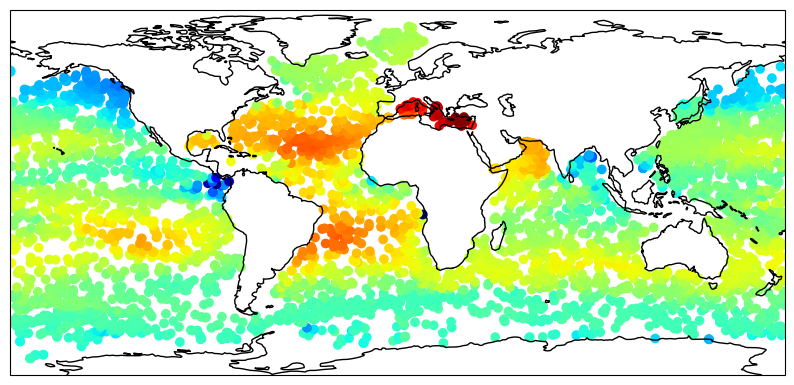

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Plot salinity
cs = plt.scatter(final_df['LONGITUDE'], final_df['LATITUDE'], c = final_df['ASAL_height0.5057600140571594'],cmap='jet')

In [31]:
pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 83.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 92.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 107.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
